# Pypi dependency

### Github Repository
A link to the repository is avaliable [here](https://github.com/MathiasDamsgaard/Comp_Social_Sci_Assigments.git).

### Contribution statement
We all helped each other with the different parts of the project. For choosing the topic and collecting the data we all helped and contributed equally. Later on, Anton took responsability for the network analysis, Andreas then stood for the textual analysis, and Mathias for the webpage and overall layout. Everyone still helped working on every part to properly agree on the final conclusions.

### Webpage
You might have to run and create the webpage first, but afterwards this [link](http://localhost:1313/Comp_Social_Sci_Assigment_B/) should work.

## Motivation

What is your dataset?

This project works to investigate a network constructed of _python packages' dependencies_ on each other. This is based on the available packages on [python package index (pypi)](https://pypi.org/). Inspiration of this project idea comes from seeing an older dataset on [Netzschleuder](https://networks.skewed.de/net/python_dependency) made by Kevin Gullikson. His [original blogpost](https://kgullikson88.github.io/blog/pypi-analysis.html) is from 2016, and will therefore be used as a baseline for comparing the networks on a timescale.

Why did you choose this/these particular dataset(s)?

We found it interesting to research how the package library in Python has evolved over the years and further investigate which packages seem to be the father/mother of all packages. Creating libraries is a big part of programming to help make functions easier to use across files and users, and thus we hope we also will gain insight into how these libraries potentially fall into different groups to see in which fields users most often create new libraries.
By also analysing the text available in README files, we hope to gain insight into how programmers formulate themselves when writing documentation for their code, and if it varies across different groups.

What was your goal for the end user's experience? The end user is someone who looks at your website. What do you want them to learn from your analysis?

Hopefully will the end user experience a breath of fresh air when reading through our analysis. It is a different and not often seen type of network, so we would like it, if the user found our research interesting not only from a computer science point of view, but also from a social scientify angle. While the project is inspiried by an interest for the idea of how the libraries will link togehter, it provides more insight into the habits of programmers, and it is this idea that we hope the end user will also learn something about, while reading through our website.

#### Imports

In [ ]:
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
# Modules
import requests
import json
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from bs4 import BeautifulSoup
import re
import xmlrpc.client as xc
from tqdm import tqdm
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import netwulf as wulf
import numpy as np
import math
import random
import community as community_louvain
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import bigrams as make_bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures
from scipy import stats
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud as wc

## Data Acqusition

In [ ]:
# Set client to the PyPI XML-RPC server
client = xc.ServerProxy('http://pypi.python.org/pypi')

# Get a list of all the packages
pypi_packages = client.list_packages()

# lowercase all the package names
pypi_packages = [package.lower() for package in pypi_packages]

# Save the list of packages
with open("data/packages.pkl", "wb") as f:
    pickle.dump(pypi_packages, f)

In [ ]:
def get_github_link(packages: list) -> list:
    """
    Function that takes a list of python packages and returns a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    
    list_of_packages: list
        List of python packages to search for.
        
    return: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    """
    
    all_links = []
    for i, package in enumerate(packages):
        # The link to the python package
        LINK = f"https://pypi.org/project/{package}/"
        
        # Get the HTML content of the page
        r = requests.get(LINK)
        
        # If the request was not successful, alert the user
        if r.status_code != 200:
            print(f"Request failed for {package, i}: {r.status_code}")
            continue
        
        # Parse the HTML content of the page
        soup = BeautifulSoup(r.content)
        
        # Get sidebar with links
        sidebar = soup.find("div", {"class": "vertical-tabs__tabs"})
        
        # Get all the links in the sidebar
        references = [link.get("href") for link in sidebar.find_all("a")]
        
        # Join into one string to regex in
        reference_text = " ".join([reference for reference in references if reference is not None])
        
        # Find the first link that contains the word "github.com"
        github_links = []
        for link in re.finditer(r"github\.com(/\w*|/\W|[-]\w*|[-]\W*)*", reference_text):
            if link.group() != "github.com/" and link.group() != "github.com":
                github_links.append(link.group())
        
        # If there are no links, append None
        if len(github_links) == 0:
            github_link = None
        
        # If there's several take the shortest and alert the user
        elif len(github_links) > 1:
            print(f"Several GitHub links found for {package, i}: {github_links}")
            github_link = min(github_links, key=len)
        
        # If there is just one link, take that out of the list
        elif len(github_links) == 1:
            github_link = github_links[0]
        
        # Else alert the user no githublink is found
        else:
            print(f"No GitHub link found for {package, i}")
            github_link = None
        
        # Append the triplet to the list
        all_links.append((package, LINK, github_link))
    
    return all_links

In [ ]:
# Load packages
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)

# Run the function with threadpool executor to speed up the process - still takes a loooong time so be aware
with ThreadPoolExecutor() as executor:
    all_links = list(tqdm(executor.map(get_github_link, [pypi_packages]), total=len(pypi_packages)))

# Clean the list of None links
all_links = [(p, l, g) for p, l, g in all_links if g is not None]

# Save the list of links
with open("data/all_links_github.json", "w") as f:
    json.dump(all_links, f)

In [ ]:
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)
print("Number of packages on pypi:", len(pypi_packages))

with open('data/all_links_github.json', 'r') as f:
    data_clean = json.load(f)
print("Number of packages to successfully get the github link from:", len(data_clean))

In [ ]:
# For each package go to the GitHub page and get the readme.text if theres a README.md
def get_readme_text(github_link: str) -> list:
    """
    Function that takes a GitHub link and returns the text of the README.md file.
    
    github_link: str
        Link to the GitHub page.
        
    return: str
        Text of the README.md file.
    """
    # If there's no link, return None
    if github_link is None:
        return None
    
    github_link = github_link.replace("github.com", "https://raw.githubusercontent.com")
    
    try:
        response = requests.get(f"{github_link}/main/README.md")
        if response.status_code != 200:
            response = requests.get(f"{github_link}/master/README.md")
            if response.status_code != 200:
                response = requests.get(f"{github_link}/main/REAMDE.rst")
                if response.status_code != 200:
                    response = requests.get(f"{github_link}/master/REAMDE.rst")
                    if response.status_code != 200:
                        response = requests.get(f"{github_link}/main/README.txt")
                        if response.status_code != 200:
                            response = requests.get(f"{github_link}/master/README.txt")
                            if response.status_code != 200:
                                return None
                            
    except Exception as e:
        print(e)
        return None
    
    readme_text = response.text

    readme_text = re.sub(r"http.*", "", readme_text)    # Remove links which start with http
    readme_text = re.sub(r"/.*|./.*|../.*", "", readme_text)    # Remove links to files in the repository which start with / or ./ or ../
    readme_text = re.sub(r"\n", " ", readme_text)    # Convert /n to space
    readme_text = readme_text.lower()    # Make all text lowercase
    readme_text = re.sub(r"[^a-z0-9-_ ]", "", readme_text)    # Only keep Alphanumeric characters and - and _
    readme_text = re.sub(r" +", " ", readme_text)    # Remove multiple spaces
    readme_text = [line for line in readme_text.split(" ") if line != ""]    # Remove empty strings

    return readme_text


def get_requirements_text(github_link: str) -> list:
    """
    Function that takes a GitHub link and returns the text of the requirements.txt file.
    
    github_link: str
        Link to the GitHub page.
        
    return: str
        Text of the requirements.txt file.
    """
    # If there's no link, return None
    if github_link is None:
        return None
    
    github_link = github_link.replace("github.com", "https://raw.githubusercontent.com")
    

    txt_bool = True
    pyproject_bool = False

    try:
        response = requests.get(f"{github_link}/main/requirements-dev.txt")
        if response.status_code != 200:
            response = requests.get(f"{github_link}/master/requirements-dev.txt")
            if response.status_code != 200:
                response = requests.get(f"{github_link}/main/dev-requirements.txt")
                if response.status_code != 200:
                    response = requests.get(f"{github_link}/master/dev-requirements.txt")
                    if response.status_code != 200:
                        txt_bool = False
                        response = requests.get(f"{github_link}/main/environment.yml")
                        if response.status_code != 200:
                            response = requests.get(f"{github_link}/master/environment.yml")
                            if response.status_code != 200:
                                pyproject_bool = True
                                response = requests.get(f"{github_link}/main/pyproject.toml")
                                if response.status_code != 200:
                                    response = requests.get(f"{github_link}/master/pyproject.toml")
                                    if response.status_code != 200:
                                        pyproject_bool = False
                                        txt_bool = True
                                        response = requests.get(f"{github_link}/main/requirements.txt")
                                        if response.status_code != 200:
                                            response = requests.get(f"{github_link}/master/requirements.txt")
                                            if response.status_code != 200:
                                                return None

    except Exception as e:
        print(e)
        return None                                

    requirements_text = response.text

    # Clean the text using regex
    cleaning_reg = r"=.*|>.*|~.*|\[.*\]|;.*|<.*|!.*"

    if txt_bool:
        # Example: 
            # versioneer[toml]
            # cython~=3.0.5
            # meson[ninja]==1.2.1
            # meson-python==0.13.1
            # pytest>=7.3.2
            # pytest-xdist>=2.2.0
            # pytest-qt>=4.2.0
        # We only want the package name and not the version or extras
        requirements_text = re.sub(r"\[.*\]", "", requirements_text)
        requirements_text = re.sub(r"#.*", "", requirements_text)        # Remove comments
        requirements_text = re.sub(f"{cleaning_reg}", "", requirements_text)        # Clean the text using regex
        requirements_text = requirements_text.lower()        # lower case
        requirements_text = requirements_text.split("\n")        # Convert to list
        requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]        # Remove empty strings

    elif pyproject_bool:
        # Example:
            # [project]
            # name = "pydata-sphinx-theme"
            # description = "Bootstrap-based Sphinx theme from the PyData community"
            # readme = "README.md"
            # requires-python = ">=3.9"
            # dependencies = [
            # "Babel",
            # "pygments>=2.7",
            # ]
            # [project.optional-dependencies]
            # doc = [
            # "numpydoc",
            # "linkify-it-py", # for link shortening
            # "myst-parser"
            # ]

        requirements_text = re.sub(r"#.*", "", requirements_text)         # Remove comments
        dependencies = re.findall(r'dependencies = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
        optional_dependencies = re.findall(r'optional-dependencies\]\n.*? = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
        if len(dependencies) == 0:
            return None
        if len(optional_dependencies) == 0:
            optional_dependencies = [""]
        
        dependencies = re.findall(r'".*"', dependencies[0])
        optional_dependencies = re.findall(r'".*"', optional_dependencies[0])
        requirements_text = dependencies + optional_dependencies
        requirements_text = [requirement[1:-1] for requirement in requirements_text]         # Remove double quotes
        requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]         # Clean the text using regex
        requirements_text = [requirement.lower() for requirement in requirements_text]         # lower case
        requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]         # Remove empty strings

    else:
        # Example:
            # name: myenv
            # channels:
            #   - defaults
            # dependencies:
            #   - numpy
            #   - pip
            #   - pip:
            #     - matplotlib
        
        requirements_text = re.sub(r"#.*", "", requirements_text)        # Remove comments
        requirements_text = re.findall(r"- .*", requirements_text)        # Only get the dependencies which start with '- '
        requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]        # Clean the text using regex
        requirements_text = [requirement.lower() for requirement in requirements_text]        # lower case
        requirements_text = [requirement[2:] for requirement in requirements_text]        # Convert to list
        requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]        # Remove empty strings

           
    return requirements_text


def node_creator(data: Tuple[str, str, str]) -> Dict[str, Any]:
    """
    Function that takes a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page and returns a dictionary with the package name as the key and the value is a dictionary with the package name, the link to the PyPI page, the link to the GitHub page, the text of the README.md file and the text of the requirements.txt file.
    
    data: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
        
    return: dict
        Dictionary with the package name as the key and the value is a dictionary with the package name, the link to the PyPI page, the link to the GitHub page, the text of the README.md file and the text of the requirements.txt file.
    """
    node = {}
    
    package, link, github_link = data

    readme_text = get_readme_text(github_link)
    requirements_text = get_requirements_text(github_link)
    if requirements_text is None:
        return None
    node[package] = {"package": package, "link": link, "github_link": github_link, "readme_text": readme_text, "requirements_text": requirements_text}
    
    return node

# Test the function
test_data = ("numpy", "https://pypi.org/project/numpy/", "github.com/numpy/numpy")
test_node = node_creator(test_data)
print(test_node)

In [ ]:
# Load clean data
with open('data/all_links_github.json', 'r') as f:
    data = json.load(f)

# Run the function with threadpool executor to speed up the process
with ThreadPoolExecutor() as executor:
    nodes = list(tqdm(executor.map(node_creator, data), total=len(data)))

# Save the list to a json file
with open("data/nodes.json", "w") as f:
    json.dump(nodes, f)

## Data Preprocessing & Description

In [ ]:
#### THIS IS THE FINAL CLEANING OF THE DATA IF NEEDED ####
with open('data/nodes.json', 'r') as f:
    data = json.load(f)

cleaned_data = []

for node in data:
    # lower the keys
    node = {key.lower(): value for key, value in node.items()}
    for key, value in node.items():
        value["package"] = value["package"].lower()
        value["requirements_text"] = [requirement.strip() for requirement in value["requirements_text"]]
        value["requirements_text"] = [requirement for requirement in value["requirements_text"] if requirement != ""]
        value["requirements_text"] = [requirement.lower() for requirement in value["requirements_text"]]
        value["requirements_text"] = [re.sub(r"==.*|>=.*|<=.*|~=.*|!=.*|>.*|<.*", "", requirement) for requirement in value["requirements_text"]]
    cleaned_data.append(node)

with open("data/nodes.json", "w") as f:
    json.dump(cleaned_data, f)

In [ ]:
# Now we make the edgelist 
# Load the data
with open('data/nodes.json', 'r') as f:
    nodes = json.load(f)

# Get names of the packages
node_names = [list(node.keys())[0] for node in nodes]

edge_list = []
packages_not_in_network = set()

for node in tqdm(nodes):
    for package in node:
        for requirement in node[package]["requirements_text"]:
            if requirement not in node_names:
                packages_not_in_network.add(requirement)
                continue
            edge_list.append((requirement, package))

print("Number of packages not in network:", len(packages_not_in_network))

# Save the edge list to a pickle file and csv for visualization
with open("data/edge_list.pkl", "wb") as f:
    pickle.dump(edge_list, f)

df = pd.DataFrame(edge_list, columns=["source", "target"])
df.to_csv("data/edge_list.csv", index=False)

In [ ]:
# Convert the list of dictionaries to a dictionary
nodes_mapping = {}

for node in nodes:
    for key, value in node.items():
        nodes_mapping[key] = value

# Join the readme text into one string
for package in nodes_mapping.keys():
    text = nodes_mapping[package]["readme_text"]
    result = " ".join(text) if text is not None else ""
    if result:
        nodes_mapping[package]["readme_text"] = result

# Save the dictionary to a csv file
df = pd.DataFrame(nodes_mapping).T
df.reset_index(inplace=True, drop=True)
df.to_csv("data/nodes_data.csv", index=False)

In [ ]:
# Load the edge list
with open("data/edge_list.pkl", "rb") as f:
    edge_list = pickle.load(f)

# Take 10% of the edge list
edge_list_sample = random.sample(edge_list, math.ceil(len(edge_list)*0.1))

G = nx.DiGraph()
G.add_edges_from(edge_list_sample)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Number of connected components:", nx.number_weakly_connected_components(G))

In [ ]:
# Get the number of nodes in each connected component
connected_components = nx.weakly_connected_components(G)
connected_components = [len(component) for component in connected_components]
connected_components = sorted(connected_components, reverse=True)

In [ ]:
# Get the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print("Number of nodes in the largest connected component:", G.number_of_nodes())

In [ ]:
# Network density
density = nx.density(G)
print(f'Network density: {density}')

# Network connection between nodes
is_connected = nx.is_weakly_connected(G)
print(f'Is the network connected: {is_connected}')

# Number of isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f'Number of isolated nodes: {len(isolated_nodes)}')

# Degree
degree = dict(G.degree())
degree_values = list(degree.values())

# Strength
strength = dict(G.degree(weight='weight'))
strength_values = list(strength.values())

# Average
avg_degree = np.mean(degree_values)
avg_strength = np.mean(strength_values)

# Median
median_degree = np.median(degree_values)
median_strength = np.median(strength_values)

# Mode
mode_degree = max(set(degree_values), key=degree_values.count)
mode_strength = max(set(strength_values), key=strength_values.count)

# Minimum
min_degree = min(degree_values)
min_strength = min(strength_values)

# Maximum
max_degree = max(degree_values)
max_strength = max(strength_values)

print(f'Degree Analysis:')
print(f'Average: {avg_degree:.2f}')
print(f'Median: {median_degree}')
print(f'Mode: {mode_degree}')
print(f'Minimum: {min_degree}')
print(f'Maximum: {max_degree}')
print(f'\nStrength Analysis:')
print(f'Average: {avg_strength:.2f}')
print(f'Median: {median_strength}')
print(f'Mode: {mode_strength}')
print(f'Minimum: {min_strength}')
print(f'Maximum: {max_strength}')

In [ ]:
# Display the graph with netwulf
wulf.visualize(G, config={'zoom': 0.6, 'node_gravity': 0.2, 'node_charge': -50,
                          'link_distance': 20, 'node_size': 15, 'node_size_variation': 0.55})

## Network Analysis

We're very interested in analysing our network and determine if it has any sort of meaningfullness/structure.
The best way to do this is using statistics, we get the necessesary baseline by generating random networks which can be used as a baseline,
thereafter we can see if there's a significant difference.

In [66]:
# Make a random network to compare
# Calculate the number of edges in the network
L = G.number_of_edges()

# Calculate the number of nodes in the network
N = G.number_of_nodes()

# Calculate the average degree of the network
k = 2*L/N
print(f"Average degree of the real network: {k:.2f}")

# Calculate the probability p
p = k/(N-1)

print(f"Probability of a link between two nodes: {p:.2e}")

#  The Erdős-Rény model is a random network model where the probability of a link between two nodes is constant and equal to p.
#  Erdős-Rény model
def generate_random_network(N, p):
    # Create an empty graph
    G = nx.Graph()

    # Add N nodes
    G.add_nodes_from(range(N))

    # Add edges between nodes with probability p
    for i in tqdm(range(N-1)):
        for j in range(i+1, N):
            if np.random.uniform() < p:
                G.add_edge(i, j)
    return G

G_rand = generate_random_network(N, p)

Average degree of the real network: 2.39
Probability of a link between two nodes: 2.90e-04


100%|██████████| 8241/8241 [01:41<00:00, 81.23it/s] 


In [67]:
print(f'Log of N: {math.log(N)}')
print(f"Average degree of the random network: {2*G_rand.number_of_edges()/G_rand.number_of_nodes():.2f}")

Log of N: 9.016998311898762
Average degree of the random network: 2.36


We see that the average degree of the real and random network have an average degree over 1, and the log(N) is higher than the average degree. This means that they fall into to supercritical network regime. However we would still expect that the real network would have a different distribution of node degrees than a random network. This is tested below

In [70]:
def make_plot(bins: list[list[int]], hists: list[list[int]], title: str, labels: list[str]):
    for bin, hist, label in zip(bins, hists, labels):
        plt.plot(bin[:-1], hist, label=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

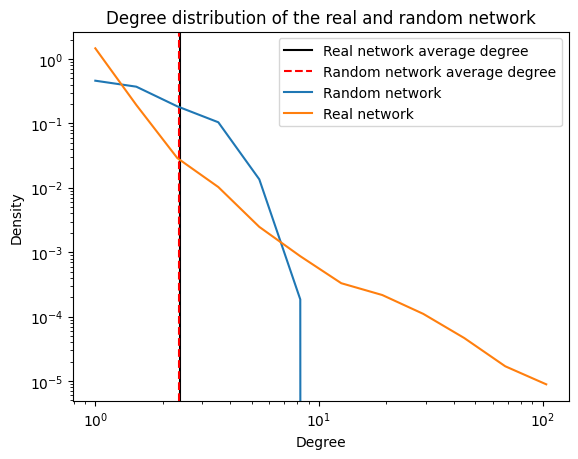

In [71]:
# Compute the distribution of degree for the random network
degree_sequence_rd = [d for _, d in G_rand.degree()]
hist_rd, bins_rd = np.histogram(degree_sequence_rd, bins=np.logspace(0, 2.2, 13), density=True)

# Compute the distribution of degree for the real network
degree_sequence = [d for _, d in G.degree()]
hist_r, bins_r = np.histogram(degree_sequence, bins=np.logspace(0, 2.2, 13), density=True)

plt.axvline(k, color='black', linestyle='-', label='Real network average degree')
plt.axvline(np.mean(degree_sequence_rd), color='red', linestyle='--', label='Random network average degree')

make_plot([bins_rd, bins_r], [hist_rd, hist_r], 'Degree distribution of the real and random network', ['Random network', 'Real network'])

We can still investigate how these hubs are interconnected. We can calculate the assortativity of the nodes:

In [ ]:
def degree_assortativity(G):
    # k_u and k_v are the degrees of nodes u and v, respectively
    k_u = []
    k_v = []
    for u, v in G.edges():
        k_u.append(G.degree(u))
        k_v.append(G.degree(v))
    
    for x, y in G.edges():
        k_u.append(G.degree(y))
        k_v.append(G.degree(x))
    
    k_u = np.array(k_u)
    k_v = np.array(k_v)
    r = ((np.mean(k_u * k_v) - np.mean(k_u) * np.mean(k_v)) /
         (np.sqrt(np.mean(k_u**2) - np.mean(k_u)**2) * np.sqrt(np.mean(k_v**2) - np.mean(k_v)**2)))

    return r

r_degree = degree_assortativity(G.to_undirected())

print(f"Degree assortativity of the real network: {r_degree:.5f}")

In [ ]:
# Configuation model: random network with a pre-defined degree sequence
def configuration_model(G: nx.Graph):
    G_copy = G.copy()
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))
    num_swaps = 10 * G_copy.number_of_edges()

    for _ in range(num_swaps):
        # b. Select two edges
        idx1, idx2 = random.sample(idxs, 2)
        e1, e2 = edges[idx1], edges[idx2]

        # NOTE: Gå ind og læs i bogen. Dette step burde ikke indgå i configuration model http://networksciencebook.com/chapter/4#generating-networks setion 4.8
        # # Ensure distinct nodes
        # if len(set(e1 + e2)) < 4:
        #     continue

        # c. Flip the direction of e1 50% of the time
        if random.random() < 0.5:
            e1 = (e1[1], e1[0])

        # Step d: Ensure new edges do not exist
        if e1[0] not in G_copy.neighbors(e2[1]) and e2[0] not in G_copy.neighbors(e1[1]):
            
            # Step e: Remove old edges and add new edges
            G_copy.remove_edges_from([e1, e2])
            G_copy.add_edges_from([(e1[0], e2[1]), (e2[0], e1[1])])
    
            edges[idx1] = (e1[0], e2[1])
            edges[idx2] = (e2[0], e1[1])

    return G_copy

G_config = configuration_model(G.to_undirected())

In [ ]:
assert all([G.degree(node) == G_config.degree(node) for node in G.nodes])

In [ ]:
G_undir = G.to_undirected()
assortativities = []
for _ in tqdm(range(20)):
    G_config = configuration_model(G_undir)
    r_config = degree_assortativity(G_config)
    assortativities.append(r_config)

# Plot the distribution of the assortativities
plt.hist(assortativities, bins=30, label='Random networks')

# Plot the assortativity of the original network
plt.axvline(r_degree, color='red', linestyle='--', label='Real network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the Configuration model network')
plt.legend()
plt.show()

In [ ]:
def degree_assortativity_directed(G: nx.DiGraph):
    # k_u and k_v are the degrees of nodes u and v, respectively
    # We get the k_u_in, k_u_out, k_v_in and k_v_out
    k_u_in = []
    k_u_out = []
    k_v_in = []
    k_v_out = []

    for u, v in G.edges():
        k_u_in.append(G.in_degree(u))
        k_v_in.append(G.in_degree(v))
        k_u_out.append(G.out_degree(u))
        k_v_out.append(G.out_degree(v))

    k_u_in = np.array(k_u_in)
    k_v_in = np.array(k_v_in)
    k_u_out = np.array(k_u_out)
    k_v_out = np.array(k_v_out)

    r_in_in = ((np.mean(k_u_in * k_v_in) - np.mean(k_u_in) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))
    
    r_out_out = ((np.mean(k_u_out * k_v_out) - np.mean(k_u_out) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_in_out = ((np.mean(k_u_in * k_v_out) - np.mean(k_u_in) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_out_in = ((np.mean(k_u_out * k_v_in) - np.mean(k_u_out) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))


    return r_in_in, r_out_out, r_in_out, r_out_in

r_in_in_real, r_out_out_real, r_in_out_real, r_out_in_real = degree_assortativity_directed(G)

print(f"In-in degree assortativity of the real network: {r_in_in_real:.5f}")
print(f"Out-out degree assortativity of the real network: {r_out_out_real:.5f}")
print(f"In-out degree assortativity of the real network: {r_in_out_real:.5f}")
print(f"Out-in degree assortativity of the real network: {r_out_in_real:.5f}")


In [ ]:
def degree_correlation_directed(G: nx.DiGraph):
    # For each node with degree k' we want to get the average of neighbor degree in and neighbor degree out

    k_u_in = {}
    k_u_out = {}
    k_v_in = {}
    k_v_out = {}

    for u, v in G.edges():
        if G.in_degree(u) not in k_u_in:
            k_u_in[G.in_degree(u)] = []
        if G.out_degree(u) not in k_u_out:
            k_u_out[G.out_degree(u)] = []
        if G.in_degree(v) not in k_v_in:
            k_v_in[G.in_degree(v)] = []
        if G.out_degree(v) not in k_v_out:
            k_v_out[G.out_degree(v)] = []

    for u, v in G.edges():
        k_u_in[G.in_degree(u)].append(G.in_degree(v))
        k_u_out[G.out_degree(u)].append(G.out_degree(v))
        k_v_in[G.in_degree(v)].append(G.in_degree(u))
        k_v_out[G.out_degree(v)].append(G.out_degree(u))
    
    
    k_u_in = {k: np.mean(v) for k, v in k_u_in.items()}
    k_u_out = {k: np.mean(v) for k, v in k_u_out.items()}
    k_v_in = {k: np.mean(v) for k, v in k_v_in.items()}
    k_v_out = {k: np.mean(v) for k, v in k_v_out.items()}

    return k_u_in, k_u_out, k_v_in, k_v_out

    
k_u_in, k_u_out, k_v_in, k_v_out = degree_correlation_directed(G)
print("Average neighbor in-degree of node with in-degree k':", k_u_in)
print("Average neighbor out-degree of node with out-degree k':", k_u_out)
print("Average neighbor in-degree of node with in-degree k':", k_v_in)
print("Average neighbor out-degree of node with out-degree k':", k_v_out)
    


In [ ]:
# Get the x values from the keys of the dictionaries
x_values = list(range(0,1000))

# Get the y values from the values of the dictionaries
y_values_in_in = [k_u_in.get(x, np.nan) for x in x_values]
y_values_out_out = [k_u_out.get(x, np.nan) for x in x_values]
y_values_in_out = [k_v_in.get(x, np.nan) for x in x_values]
y_values_out_in = [k_v_out.get(x, np.nan) for x in x_values]

# Plot the degree correlation
plt.plot(x_values, y_values_in_in, label='In-in degree correlation')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation')

# logscale
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")

# Place the legend top right corner
plt.legend(loc='upper right')

plt.show()



In [ ]:
# We do a degree preserving randomisation : R-S randomization to the plot
def degree_preserving_randomization(G: nx.DiGraph):
    # Create a copy of the graph
    G_copy = G.copy()

    # Get the edges
    edges = list(G_copy.edges())

    # Get the number of edges
    num_swaps = 10 * G_copy.number_of_edges()

    # For each swap
    for _ in range(num_swaps):
        # Select two sets of connected
        u, v = random.choice(edges)
        x, y = random.choice(edges)

        # Ensure distinct nodes
        if len(set([u, v, x, y])) < 4:
            continue

        # Ensure that the new edges do not exist
        if x not in G_copy.neighbors(v) and y not in G_copy.neighbors(u):
            # Remove the old edges
            G_copy.remove_edges_from([(u, v), (x, y)])

            # Add the new edges
            G_copy.add_edges_from([(u, y), (x, v)])

            # Update the edges
            edges[edges.index((u, v))] = (u, y)
            edges[edges.index((x, y))] = (x, v)
        

    return G_copy

G_degree_randomized = degree_preserving_randomization(G)
k_u_in_randomized, k_u_out_randomized, k_v_in_randomized, k_v_out_randomized = degree_correlation_directed(G_degree_randomized)



In [ ]:
x_values = list(range(0,1000))

y_values_in_in_randomized = [k_u_in_randomized.get(x, np.nan) for x in x_values]
y_values_out_out_randomized = [k_u_out_randomized.get(x, np.nan) for x in x_values]
y_values_in_out_randomized = [k_v_in_randomized.get(x, np.nan) for x in x_values]
y_values_out_in_randomized = [k_v_out_randomized.get(x, np.nan) for x in x_values]

plt.figure(figsize=(12, 10))

plt.plot(x_values, y_values_in_in, label='In-in degree correlation', color='blue', marker = 'o')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation', color='orange', marker='o')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation', color='green', marker='o')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation', color='red', marker='o')

plt.plot(x_values, y_values_in_in_randomized, label='In-in degree correlation randomized', linestyle='None', marker = 'D', color = 'blue', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_out_randomized, label='Out-out degree correlation randomized', linestyle='None', marker = 'D', color = 'orange', markerfacecolor = 'None') 
plt.plot(x_values, y_values_in_out_randomized, label='In-out degree correlation randomized', linestyle='None', marker = 'D', color = 'green', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_in_randomized, label='Out-in degree correlation randomized', linestyle='None', marker = 'D', color = 'red', markerfacecolor = 'None')

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")

plt.legend(loc='upper right')

plt.show()

In [ ]:
# Make the same two plots with the degree preserving randomization
r_in_in_R_S = []
r_out_out_R_S = []
r_in_out_R_S = []
r_out_in_R_S = []

for _ in tqdm(range(20)):
    G_R_S = degree_preserving_randomization(G)
    r_in_in, r_out_out, r_in_out, r_out_in = degree_assortativity_directed(G_R_S)
    r_in_in_R_S.append(r_in_in)
    r_out_out_R_S.append(r_out_out)
    r_in_out_R_S.append(r_in_out)
    r_out_in_R_S.append(r_out_in)




In [ ]:
# Plot the distribution of the assortativities
plt.hist(r_in_in_R_S, bins=30, label='In-in degree assortativity', color='red')
plt.hist(r_out_out_R_S, bins=30, label='Out-out degree assortativity', color='green')
plt.hist(r_in_out_R_S, bins=30, label='In-out degree assortativity', color='blue')
plt.hist(r_out_in_R_S, bins=30, label='Out-in degree assortativity', color='orange')

# Plot the assortativity of the original network
plt.axvline(r_in_in_real, color='red', linestyle='--', label='Real network In-in')
plt.axvline(r_out_out_real, color='green', linestyle='--', label='Real network Out-out')
plt.axvline(r_in_out_real, color='blue', linestyle='--', label='Real network In-out')
plt.axvline(r_out_in_real, color='orange', linestyle='--', label='Real network Out-in')

plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the random networks (R-S randomization)')
plt.legend()
plt.show()

In [ ]:
# Instead plot it as a line plot where the x_values are in_in, in_out, out_in, out_out:
x_values = ['In-in', 'In-out', 'Out-in', 'Out-out']

# Get the y values from the values of the dictionaries
y_values = [r_in_in_real, r_in_out_real, r_out_in_real, r_out_out_real]

fig = plt.figure()
plt.plot(x_values, y_values, label='Real network')
for i, (r_in_in, r_out_out, r_in_out, r_out_in) in enumerate(zip(r_in_in_R_S, r_out_out_R_S, r_in_out_R_S, r_out_in_R_S)):
    y_values = [r_in_in, r_in_out, r_out_in, r_out_out]
    plt.plot(x_values, y_values, alpha=0.25, color='red')

plt.xlabel("Degree correlation")
plt.ylabel("Assortativity")
plt.title("Assortativity of the random networks (R-S randomization)")
plt.legend()
plt.show()

### Part 1 of Conclusion on the Graph Analysis.
The network of github is not random and it shows very clear signs of dissortativity

In [ ]:
# Find the 5 most central packages according to degree centrality.
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print(f'The 5 most central scientists according to closeness centrality are: {[str(package) for package, centrality in sorted_closeness_centrality[:5] ]}')

# Find the 5 most central packages according to eigenvector centrality.
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print(f'The 5 most central scientists according to eigenvector centrality are: {[str(package) for package, centrality in sorted_eigenvector_centrality[:5] ]}')

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
degree = dict(G.degree())
plt.scatter(list(closeness_centrality.values()), list(degree.values()))
plt.xlabel('Closeness centrality')
plt.ylabel('Degree')
plt.show()

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G)
degree = dict(G.degree())
plt.scatter(list(eigenvector_centrality.values()), list(degree.values()))
plt.xlabel('Eigenvector centrality')
plt.ylabel('Degree')
plt.show()

### Part 2 of Conclusion on Graph Analysis.
bla bla

## Textual analysis of the found communities

In [ ]:
# Find and assign all the communities to the dictionary
# First make the graph undirected: https://github.com/taynaud/python-louvain/issues/28 
# De snakker heller ikke rigtigt om hvordan man skulle gøre i bogen. Derudover er tidskompleksiteten O(L) af louvain

G_undir = G.to_undirected()
partitioning = community_louvain.best_partition(G_undir)
print(len(set(partitioning.values())))
print({k: len([v for v in partitioning.values() if v == k]) for k in set(partitioning.values())})

In [ ]:
G_undir = G.to_undirected()
partition = nx.community.louvain_communities(G_undir)
print(len(partition))
print({i: len([v for v in p]) for i, p in enumerate(partition)})
print(nx.community.modularity(G_undir, partition))

In [ ]:
colors = [partitioning[node] for node in G.nodes]
nx.draw(G, with_labels=False, node_color=colors)
# TODO: Show the modularity

In [ ]:
# Map a community number into one of 47 unique colors
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = plt.get_cmap('gist_ncar')
colors = [cmap(i) for i in np.linspace(0, 1, )]
colors = [colors[community] for community in partitioning.values()]

# Map the color to the corresponding package and save the pairs into a csv file
community_color = {package: color for package, color in zip(G.nodes, colors), partitioning}
community_color = pd.DataFrame(community_color.items(), columns=['id', 'color'])
community_color.to_csv("data/community_color.csv", index=False)

In [ ]:
df = pd.read_csv("data/nodes_data.csv")
df = df.dropna(subset=['readme_text'])
# # Take 1/10 of the data
# df_subset = df.sample(frac=0.1, random_state=42)
# df = df_subset

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def tokenize(text, stopwords=stop_words, stemmer=stemmer):
    if text is None or '':
        return ''
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords]

    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Apply the function to the readme's
df["tokens"] = df["readme_text"].apply(tokenize)

# Combine the tokens from all abstracts into one comprehensive list.
all_tokens = df["tokens"].sum()

In [ ]:
# Bigrams and contingency tables

# Function that creates bigrams from a list of tokens
bigrams = list(make_bigrams(all_tokens))
bigram_counts = Counter(bigrams)

# Function that creates a contingency table for a bigram
# Create a BigramCollocationFinder object that also stores tables at the same time
finder = BigramCollocationFinder.from_words(all_tokens)

# Computes for each unique bigram the chi-squared statistic between the observed and expected contingency tables
# Filter bigrams based on chi-squared
collocations_chisq = finder.score_ngrams(BigramAssocMeasures().chi_sq)

# Compute p-values for the chi-squared statistics
# Calculate chi-squared to get p-value
collocations_p = []
for bigram, chi_squared in tqdm(collocations_chisq):
    collocations_p.append((bigram, stats.chi2.sf(chi_squared, 1)))

# Find the list of bigrams that appear more than 50 times and have p-value smaller than 0.001
# Filter collocations based on p-value
collocations = [bigram for bigram, p_value in collocations_p if bigram_counts[bigram] > 50 and p_value < 0.001]

# Find the top 20 of them by number of occurrences
print(f'Top 20 collocations by number of occurrences: {collocations[:20]}')

# Combine collocations into a single token
collocation_tokens = ['_'.join(bigram) for bigram in collocations]

In [ ]:
def tokenize_with_collocations(text, collocations=collocation_tokens, stopwords=stop_words, stemmer=stemmer):
    if text is None or '':
        return ''
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Check all tokens and replace collocations with a single token
    for i in range(len(tokens) - 1):
        if f'{tokens[i]}_{tokens[i + 1]}' in collocations:
            tokens[i] = f'{tokens[i]}_{tokens[i + 1]}'
            tokens[i + 1] = ''
    tokens = [word for word in tokens if word != '']

    return tokens

# Apply the function to the readme's
df["tokens"] = df["readme_text"].apply(tokenize_with_collocations)


In [ ]:
# Use the partitioning for the packages get a coloumn with their partitioning in the df:
df['partition'] = df['package'].map(partitioning)


In [ ]:
# Select the 10 most occuring communities by filtering the dataframe on partitioning to get the top 10 most occuring:
top_10_communities = df['partition'].value_counts().head(10).index

# Filter the dataframe on the top 10 communities
df_top_10 = df[df['partition'].isin(top_10_communities)]

# Create a dictionary with the top 10 communities and the corresponding tokens
top_10_community_terms = {}

for community in top_10_communities:
    tokens = df_top_10[df_top_10['partition'] == community]['tokens'].sum()
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([' '.join(tokens)])
    terms = vectorizer.get_feature_names_out()
    top_10_community_terms[community] = terms

# Get the 3 packages with most out nodes in each community
top_3_packages = {}

for community in top_10_communities:
    out_degrees = dict(G.out_degree())
    community_nodes = [node for node in G.nodes if partitioning[node] == community]
    out_degrees_community = {node: out_degrees[node] for node in community_nodes}
    top_3_packages[community] = sorted(out_degrees_community, key=out_degrees_community.get, reverse=True)[:3]





In [ ]:
# Create a wordcloud with the information on the communities:
for community in top_10_communities:
    terms = top_10_community_terms[community]
    text = ' '.join(terms)
    wordcloud = wc.WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.text(700, -30, f'Community {community}', fontsize=14, color='black', ha='center')
    
    plt.text(0, -50, f'Top 3 packages: {top_3_packages[community][0]}', fontsize=12, color='black', zorder=1)
    plt.text(0, -30, f'{top_3_packages[community][1]}', fontsize=12, color='black', zorder=2)
    plt.text(0, -10, f'{top_3_packages[community][2]}', fontsize=12, color='black', zorder=3)
    
    
    plt.show()